# Introduction

Begin date: 2022-10-09 \
End date: 2022-10-11 \
Author: Xin Guo

Sub-question: Was there a significant difference in the amount of exercise participants did in summer and winter, and if so, how should we describe this difference?

This is the code that test on the other two datasets: participant 4, participant7

Below is the modules that are required in analysing. 
pandas is for loading data from csv to jupyter; 
matplotlib is for visualizing the result; 
datetime is for processing date and time format. 

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

# Data clean and aggregation

Below is the read data from folders

In [26]:
# dataset: Participant-04
raw_data = pd.read_csv("https://raw.github.sydney.edu.au/xguo0149/2022-DATA3406-RE06-Group04/main/src/resources/Participant-04.csv?token=GHSAT0AAAAAAAAAHGMSLS5R4FVB62OCDOBUY3J2HYA")

# second method
# raw_data = pd.read_csv("resources/Participant-04.csv")



# dataset: Participant-07
# raw_data = pd.read_csv("https://raw.github.sydney.edu.au/xguo0149/2022-DATA3406-RE06-Group04/main/src/resources/Participant-07.csv?token=GHSAT0AAAAAAAAAHGMTNSM2ZW5TQU5Z3XLYY3J2IHA")

# second method
# raw_data = pd.read_csv("resources/Participant-07.csv")

Below is converting the format: 
- convert date into standard format: YYYY-MM-DD HH:MM:SS
- modify the variables' name which are only including lower case letters, digits and underscore 

In [27]:
raw_data['Start']=pd.to_datetime(raw_data['Start'])
raw_data['Finish']=pd.to_datetime(raw_data['Finish'])

raw_data.rename(columns = {'Start': 'start', 'Finish': 'finish', 'Steps (count)':'steps_count'}, inplace = True)
raw_data

,start,finish,steps_count
0,2022-01-01 00:00:00,2022-01-01 01:00:00,0.0
1,2022-01-01 01:00:00,2022-01-01 02:00:00,0.0
2,2022-01-01 02:00:00,2022-01-01 03:00:00,0.0
3,2022-01-01 03:00:00,2022-01-01 04:00:00,0.0
4,2022-01-01 04:00:00,2022-01-01 05:00:00,0.0
...,...,...,...
6018,2022-09-08 17:00:00,2022-09-08 18:00:00,537.0
6019,2022-09-08 18:00:00,2022-09-08 19:00:00,188.0
6020,2022-09-08 19:00:00,2022-09-08 20:00:00,215.0
6021,2022-09-08 20:00:00,2022-09-08 21:00:00,727.0


Result: the two columns `start` and `finish` has been converted to the standard format, the columns' names are all lower case.

Below is converting float in the variable `steps_count` into integer

In [28]:
raw_data['steps_count'] = raw_data['steps_count'].astype(int)

Below is aggregating data by day: I use the `groupby` funtion via the start date to aggregate all the data in one day. Variable `steps_count` is the sum of steps. 

In [29]:
raw_data_by_day =  raw_data.groupby(by = raw_data['start'].dt.date).sum().reset_index()
raw_data_by_day['steps_count'] = raw_data_by_day['steps_count'].astype(int)

raw_data_by_day

,start,steps_count
0,2022-01-01,6290
1,2022-01-02,17810
2,2022-01-03,8168
3,2022-01-04,8840
4,2022-01-05,8338
...,...,...
246,2022-09-04,6270
247,2022-09-05,8596
248,2022-09-06,13997
249,2022-09-07,10513


Result: the aggregated dataframe includes two columns `start` the date and `steps_count` steps in the day. 

Below is spliting winter's steps data, we use the data in January and February. 

In [30]:
df1 = raw_data[raw_data['start'].dt.month == 1 ].groupby(by = raw_data['start'].dt.date).sum()

df2 = raw_data[raw_data['start'].dt.month == 2 ].groupby(by = raw_data['start'].dt.date).sum()

df3 = raw_data[raw_data['start'].dt.month == 3 ].groupby(by = raw_data['start'].dt.date).sum()

raw_data_winter = pd.concat([df1, df2, df3])
raw_data_winter

,steps_count
start,
2022-01-01,6290
2022-01-02,17810
2022-01-03,8168
2022-01-04,8840
2022-01-05,8338
...,...
2022-03-27,7568
2022-03-28,6790
2022-03-29,17980


**Result**: Daily steps data of participant-8 in winter is stored in `raw_data_winter`

Below is spliting summar's daily steps data, we use the data in June and July. 

In [31]:
df1 = raw_data[raw_data['start'].dt.month == 6 ].groupby(by = raw_data['start'].dt.date).sum()

df2 = raw_data[raw_data['start'].dt.month == 7 ].groupby(by = raw_data['start'].dt.date).sum()

df3 = raw_data[raw_data['start'].dt.month == 8 ].groupby(by = raw_data['start'].dt.date).sum()

raw_data_summar = pd.concat([df1, df2, df3])
raw_data_summar

,steps_count
start,
2022-06-01,11708
2022-06-02,16548
2022-06-03,4480
2022-06-04,27160
2022-06-05,3396
...,...
2022-08-27,11366
2022-08-28,5170
2022-08-29,14682


**Result**: Daily steps data of participant-8 in winter is stored in `raw_data_summar`

Below is plot of steps in each day. x-axis is the date, y-axis is count of steps in the day. 

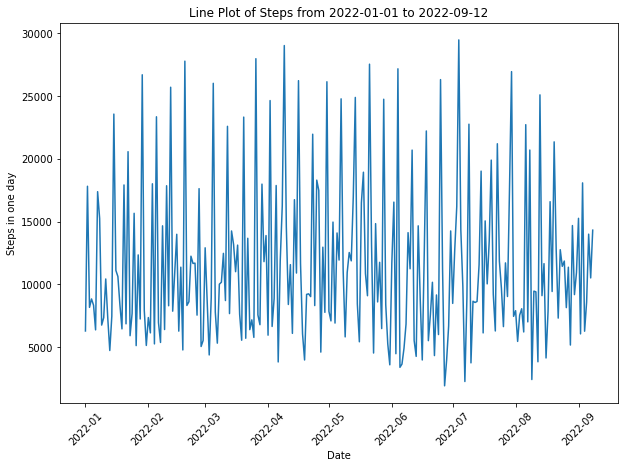

In [32]:

start = raw_data_by_day['start']
steps = raw_data_by_day['steps_count']
 
# Figure Size
fig = plt.figure(figsize =(10, 7))
 
#  line Plot
plt.plot(start, steps)

plt.xlabel("Date")
plt.ylabel("Steps in one day")
plt.title("Line Plot of Steps from 2022-01-01 to 2022-09-12")

plt.xticks(rotation=45)

# Show Plot
plt.show()

Result:
As can be seen from the graphs, the amount of daily exercise varied considerably among the participants. The maximum amount of exercise per day was over 20,000 steps and the minimum amount was around 2,000 steps. There was a significant decrease in the participant's exercise in June and July, and given that it was winter in Sydney in June and July, we suspect that the weather may have influenced the participant's exercise level.

Therefore, further analysis is needed, i.e. to look at the total weekly exercise.

Below is aggregate daily data into weekly data using the `resample` function. We set Monday as the first day of a week. 
We keep the step count is an interger in each row, a float of steps does not make sense.

In [33]:
raw_data_by_week = pd.DataFrame(raw_data.resample('W-MON', on='start').steps_count.sum()).reset_index()
raw_data_by_week['steps_count'] = raw_data_by_week['steps_count'].astype(int)

raw_data_by_week

,start,steps_count
0,2022-01-03,32268
1,2022-01-10,70286
2,2022-01-17,75247
3,2022-01-24,73738
4,2022-01-31,80114
5,2022-02-07,72440
6,2022-02-14,91653
7,2022-02-21,81120
8,2022-02-28,71356
9,2022-03-07,74020


Result:
The aggregated dataframe includes two columns: `start` date of Monday in a week and `steps_count`the steps in the week. 

Below is the bar plot of weekly total steps. X-axis is date of a week, y-axis is the steps in the week. 

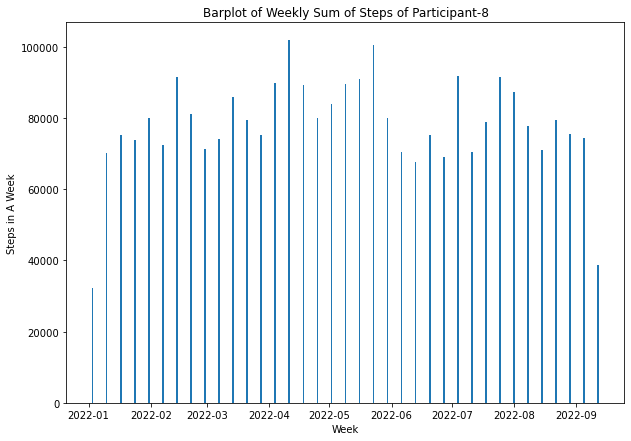

In [34]:
start = raw_data_by_week['start']
steps = raw_data_by_week['steps_count']
 
# Figure Size
fig = plt.figure(figsize =(10, 7))
 
#  bar Plot
plt.bar(start, steps)

plt.title("Barplot of Weekly Sum of Steps of Participant-8")
plt.xlabel("Week")
plt.ylabel("Steps in A Week")
 
# Show Plot
plt.show()

The bar chart above shows a gradual increase in exercise for this participant from January to May, with a sudden decrease in June; this is consistent with the results we observed from the daily exercise. Then there was a gradual increase in exercise from June to September.

# Model Prediction: ARMA



Autoregressive Moving Average (ARMA) is a theoretical statistical model that uses past data to predict future data. This method is mostly used to predict the future of weather, stocks, etc. It is a type of self-regression model.

The following sets the index of each row to a date instead of a number. This is done because using the ARMA model requires the data type to be an integer or floating point number.

In [35]:
raw_data_by_day.index = raw_data_by_day["start"]
raw_data_by_day

,start,steps_count
start,,
2022-01-01,2022-01-01,6290
2022-01-02,2022-01-02,17810
2022-01-03,2022-01-03,8168
2022-01-04,2022-01-04,8840
2022-01-05,2022-01-05,8338
...,...,...
2022-09-04,2022-09-04,6270
2022-09-05,2022-09-05,8596
2022-09-06,2022-09-06,13997


The variable `date` has been set as the index, and the data frame still contains two variables. \
So we need to remove the date column to ensure that the data frame only contains data of integer and floating point types:

In [36]:
del raw_data_by_day["start"]
raw_data_by_day

,steps_count
start,
2022-01-01,6290
2022-01-02,17810
2022-01-03,8168
2022-01-04,8840
2022-01-05,8338
...,...
2022-09-04,6270
2022-09-05,8596
2022-09-06,13997


We have removed the date column. By now we have finished preparing the data format.

In order to train the prediction model, we need to separate the training set from the test set to avoid overfitting the model. The training set is used to generate the model and the test set is used to check the accuracy of the model. \

We choose the last 30 days of the training set as the test set

In [37]:
raw_data_by_day.tail(30)

,steps_count
start,
2022-08-10,9464
2022-08-11,9403
2022-08-12,3838
2022-08-13,25085
2022-08-14,9102
2022-08-15,11649
2022-08-16,4141
2022-08-17,7883
2022-08-18,16582


The data from August 14, 2022 to September 12, 2022 is the test set

The following is the separation of the test set and training set, August 14 is the bound of spltting.

In [38]:
train_set = raw_data_by_day[raw_data_by_day.index < pd.to_datetime("2022-08-14", format='%Y-%m-%d')]
test_set = raw_data_by_day[raw_data_by_day.index >= pd.to_datetime("2022-08-14", format='%Y-%m-%d')]

D:\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Here is the process of training the model and using it to predict the number of steps per day: 

In [39]:
# using the data in training set genrarating the ARMA model
y = train_set['steps_count']
ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

# using the ARMA model predicting the test set
y_pred = ARMAmodel.get_forecast(len(test_set.index))

# the confident level is set to 0.05
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test_set.index
y_pred_out = y_pred_df["Predictions"] 

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [40]:
y_pred_out.head(5)

start
2022-08-14    11539.613079
2022-08-15    11539.605033
2022-08-16    11539.596986
2022-08-17    11539.588940
2022-08-18    11539.580894
Name: Predictions, dtype: float64

Above is the predicted number of steps from August 14 to September 12, which shows the decreasing number of steps. \

We visualise the predicted results and the actual results and check the accuracy: 

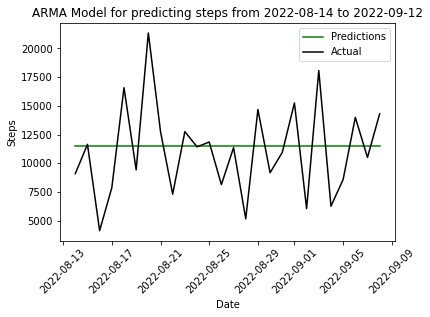

In [41]:
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.plot(test_set, color='black', label = 'Actual')

plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Steps")
plt.title("ARMA Model for predicting steps from 2022-08-14 to 2022-09-12")

plt.legend()

As you can see from the graph above, the trend of the ARMA model is correct, i.e. the number of steps per day for the participant decreases from August 14th. The disadvantage of the ARMA model is that it does not capture the periodicity in the data, which is the reason for the linear decrease in the predicted results. Therefore, in order to capture the periodicity of the data, we will use a time series data decomposition method to isolate the periodic variation.

The following is the RMSE of the ARMA model: 

In [42]:
arma_rmse = np.sqrt(mean_squared_error(test_set["steps_count"].values, y_pred_df["Predictions"]))

print("The root mean squared error of ARMA model is {:.2f}".format(arma_rmse))

The root mean squared error of ARMA model is 4051.13


# Compare steps between Summar and Winter: Decomposition of Time Series

The decomposition of the time series data is as follows: 

$$
X_k = a_k + b_k + r_k
$$

$k$: $k^{th}$ observation $\newline$
$X_k$ denotes observations $\newline$
$a_k$ denotes the trend component, it represents the long-term trend of the data, usually one of up, down or constant $\newline$
$b_k$ denotes the period component, it represents the cyclical behaviour in the data. For example, in the case of the ARMA model, the participant has a large fluctuation every once in a while. $\newline$
$r_k$ denotes the residual component, it is usually the remainder of the trend and cyclicality that is removed

Below is the decomposition process, where we focus on the trend and seasonality components of the data: 

In the decomposition process above, we have chosen a periodicity of 35, as this data set contains approximately 35 weeks of steps

Below is the analysis of data in winter, which we choose data in January, February and March. We analyse the trend and seasonality in the chosen data 

In [43]:
decomposition_add = seasonal_decompose(raw_data_winter, model='additive', period=35)



trend = decomposition_add.trend
season = decomposition_add.seasonal
# residual = decomposition_add.resid


Below is the visualisation of the components of trend and seasonality.

Text(0, 0.5, 'Step Count')

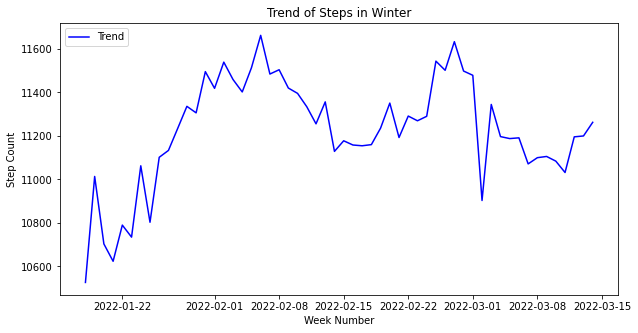

In [44]:
# Plotting the time series and it's components together

fig, axes = plt.subplots(1, 1, sharex=True, sharey=False)
fig.set_figheight(5)
fig.set_figwidth(10)

# First plot to the Original time series
# axes[0].plot(raw_data_by_day["steps_count"], label='Original', color = "black") 
# axes[0].legend(loc='upper left')

# first plot to be for trend
axes.plot(trend, label='Trend', color = "blue")
axes.legend(loc='upper left')
axes.title.set_text('Trend of Steps in Winter')
axes.set_xlabel('Week Number')
axes.set_ylabel('Step Count')


# Second plot to be Seasonality component
# axes[1].plot(season, label='Seasonality', color = "green")
# axes[1].legend(loc='upper left')

# last last plot to be Residual component
# axes[3].plot(residual, label='Residuals')
# axes[3].legend(loc='upper left')

As can be seen from the images in the trend section(Red line): 

- The number of steps taken by the participant increases gradually from 2022-01-15 to 2022-02-10, with the total number of steps reaching a maximum on 2022-02-10. 
- From 2022-02-10 to 2022-03-01, the number of steps decreases.
- From 2022-03-01, the number of steps increased. \
  
The trend for these three time periods is the same as the trend we made above for the weekly step totals, which suggests that the trend we isolated is partially correct.

As can be seen from the cyclical component(Green line):  
- The length of each cycle is approximately one month
- Each cycle has 4 to 5 heavy movements, with a peak of 4000 steps

In [45]:
decomposition_add = seasonal_decompose(raw_data_summar, model='additive', period=35)



trend = decomposition_add.trend
season = decomposition_add.seasonal
residual = decomposition_add.resid

Below is the visualisation of the components of trend and seasonality.

Text(0, 0.5, 'Step Count')

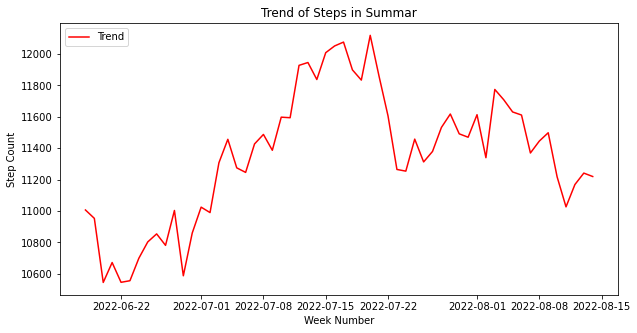

In [46]:
# Plotting the time series and it's components together

fig, axes = plt.subplots(1, 1, sharex=True, sharey=False)
fig.set_figheight(5)
fig.set_figwidth(10)

# First plot to the Original time series
# axes[0].plot(raw_data_by_day["steps_count"], label='Original', color = "black") 
# axes[0].legend(loc='upper left')

# second plot to be for trend
axes.plot(trend, label='Trend', color = "red")
axes.legend(loc='upper left')
axes.title.set_text('Trend of Steps in Summar')
axes.set_xlabel('Week Number')
axes.set_ylabel('Step Count')


# third plot to be Seasonality component
# axes[1].plot(season, label='Seasonality', color = "green")
# axes[1].legend(loc='upper left')

# last last plot to be Residual component
# axes[3].plot(residual, label='Residuals')
# axes[3].legend(loc='upper left')

As can be seen from above trend plot(red line):

- Steps increased from 7700 to 9500 from 2022-06-15 to 2022-08-15

As can be seen from above seasonality plot(green line):

- The length of a cycle is approximately 40 days. 

- Wide range of fluctuations within a cycle。 

In [47]:
raw_data_by_week

pd.concat([raw_data_by_week, raw_data_by_week]).sort_values("start")

,start,steps_count
0,2022-01-03,32268
0,2022-01-03,32268
1,2022-01-10,70286
1,2022-01-10,70286
2,2022-01-17,75247
...,...,...
34,2022-08-29,75418
35,2022-09-05,74393
35,2022-09-05,74393
36,2022-09-12,38825


Below is putting the summar and winter trend into one plot. 

Text(0, 0.5, 'Step Count')

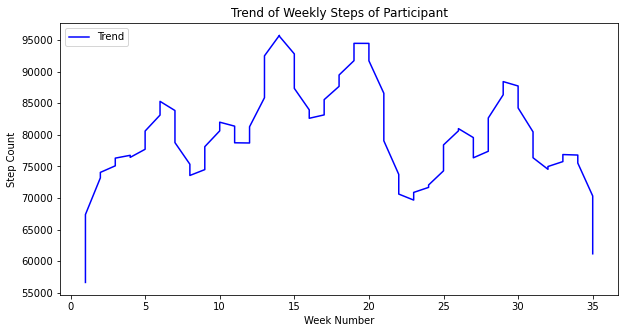

In [48]:
data1 = pd.concat([raw_data_by_week, raw_data_by_week]).sort_values("start")

# data1["Steps (count)"] = data1["Steps (count)"].astype(int)

# generate seasonality decomposition additive analysis
decomposition_add = seasonal_decompose(data1["steps_count"], model='additive', period=4)

# the analysis includes two part: trend and seasonality
trend = decomposition_add.trend
season = decomposition_add.seasonal

# plot: set the legnth and width of plot
fig, axes = plt.subplots(1, 1, sharex=True, sharey=False)
fig.set_figheight(5)
fig.set_figwidth(10)

# plot: line plot; set legend, legend location,, x label, ylabel, title
axes.plot(trend, label='Trend', color = "blue")
axes.legend(loc='upper left')
axes.title.set_text('Trend of Weekly Steps of Participant')
axes.set_xlabel('Week Number')
axes.set_ylabel('Step Count')

# Reflection

### How could we predict the steps in one day(or week)?

- First we need to determine the baseline activity level of the participant, i.e. how many steps are normally taken in a week

- Then we need to look at the trend over the predicted time period, i.e. whether it will increase or decrease over the predicted time period compared to the data already given

- Finally, we need to see what day of the month (week) we are predicting, and add the corresponding period amount

### What could be done better in the future?

- Use cross-validation for the decompose model and calculate the accuracy of the model

- The amount of data is not large enough, the aggregated data is only about two hundred days.

- The ARMA model and the decomposition model are combined to produce a more accurate forecast model

# Reference

- A Guide to Time Series Forecasting in Python | Built In. (n.d.). Builtin.com. https://builtin.com/data-science/time-series-forecasting-python

- admin. (n.d.). 10. Decomposition of Time-Series in Python: Trend and Seasonal (Periodic) Components | Fusion of Engineering, Control, Coding, Machine Learning, and Science. Retrieved October 12, 2022, from https://aleksandarhaber.com/decomposition-of-time-series-in-python-trend-and-seasonal-periodic-components/

- How to decompose a time series? -. (n.d.). ProjectPro. Retrieved October 12, 2022, from https://www.projectpro.io/recipes/decompose-time-series

- Getting started with Time Series Decomposition in Python. (n.d.). Engineering Education (EngEd) Program | Section. https://www.section.io/engineering-education/time-series-decomposition-in-python/